# Zone axis alignment

In this notebook, we will find the necessary angles to tilt the sample such that a given zone axis is aligned with the optical axis.

In [1]:
# Import the necessary packages
%matplotlib inline
from matplotlib import pyplot as plt
from orix.vector import Vector3d, Miller
import numpy as np

from tiltlib import Axis, Sample

## Load data

We use Orix's austenite crystal map, and a double-tilt sample holder with axes offset by 30 degrees to the scan.

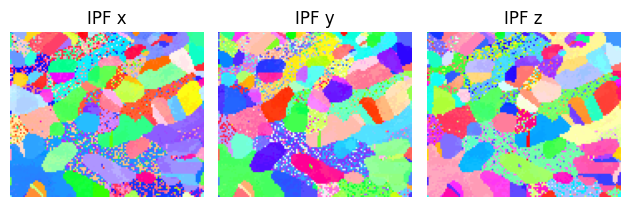

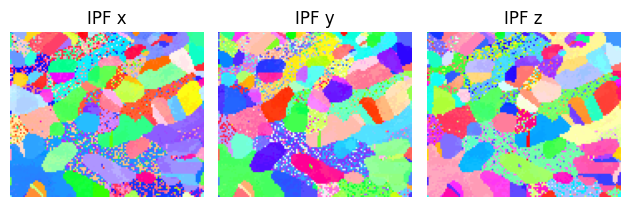

In [2]:
from orix.data import sdss_austenite

# This is the raw data we will use
raw_xmap = sdss_austenite(allow_download=True)

x_tilt_axis = Axis(
    Vector3d.xvector().rotate(Vector3d.zvector(), np.deg2rad(30)),
    min=-30, 
    max=30,
    angle=0,
    intrinsic=False,
)
y_tilt_axis = Axis(
    Vector3d.yvector().rotate(Vector3d.zvector(), np.deg2rad(30)),
    min=-30, 
    max=30,
    angle=0,
    intrinsic=True,
) 

sample = Sample(raw_xmap, [x_tilt_axis, y_tilt_axis])

sample.plot()


# Grain selection

We choose a grain as a target for our optimization with a hyperspy ROI

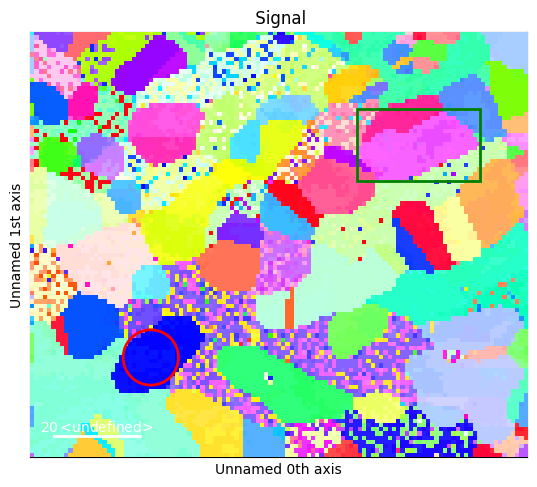

In [14]:
nav = sample.to_navigator()
nav.plot()

from hyperspy.roi import RectangularROI, CircleROI

box = RectangularROI(left=77, top=18, right=106, bottom=35)
box.interactive(nav)

circle = CircleROI(cx=28, cy=76, r=6.5)
# There is an error we don't care about
try:
    circle.interactive(nav, color="red")
except np.exceptions.DTypePromotionError:
    pass

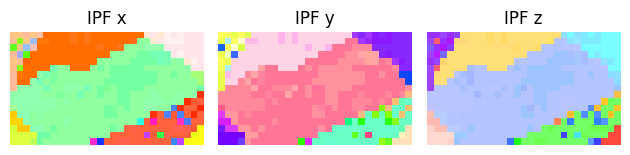

In [4]:
box_crop = sample.crop(box)
box_crop.plot()

circle_crop = sample.crop(circle)
# The data shape is no longer rectangular, so plotting is difficult


## Find the tilt angles

Now, we choose a miller index, e.g. [1 1 1], and find the angles necessary for aligning the grain to that zone axis

In [5]:
target = Miller(uvw=[1, 1, 1], phase=sample.xmap.phases[0])

box_angles = box_crop.find_tilt_angles(target)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 4.212431246103031
             x: [-2.003e+01 -2.473e+00]
           nit: 90
          nfev: 174
 final_simplex: (array([[-2.003e+01, -2.473e+00],
                       [-2.003e+01, -2.472e+00],
                       [-2.003e+01, -2.473e+00]]), array([ 4.212e+00,  4.212e+00,  4.212e+00]))


box_angles = array([-20.03128554,  -2.47251228]) degrees


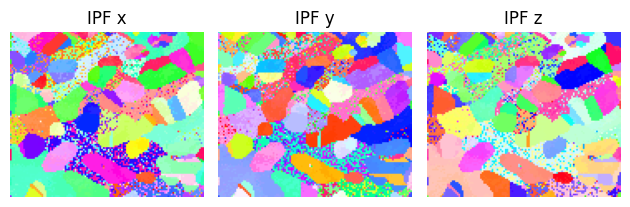

In [6]:
sample.rotate_to(*box_angles, degrees=True)
sample.plot()
print(f"{box_angles = } degrees")

The grain we chose is indeed close to [1 1 1], as expected.
Next, we will do the same with the circle ROI

In [7]:
circle_angles = circle_crop.find_tilt_angles(target)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.671642311118573
             x: [-1.103e+00  1.471e+01]
           nit: 94
          nfev: 192
 final_simplex: (array([[-1.103e+00,  1.471e+01],
                       [-1.103e+00,  1.471e+01],
                       [-1.103e+00,  1.471e+01]]), array([ 6.716e-01,  6.716e-01,  6.716e-01]))


circle_angles = array([-1.1028204 , 14.70649067]) degrees


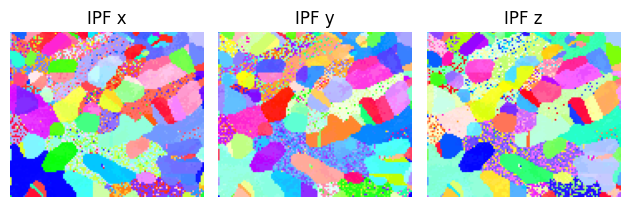

In [8]:
sample.rotate_to(*circle_angles, degrees=True)
sample.plot()
print(f"{circle_angles = } degrees")

Once again, we see that the desired grain has been aligned with [1 1 1].